In [111]:
import jax
import jax.numpy as jnp
from ripplegw.constants import gt, m_per_Mpc, PI, TWO_PI, MRSUN, C
from ripplegw.waveforms.IMRPhenomXAS_NRTidalv3 import gen_IMRPhenomXAS_NRTidalv3_hphc, gen_IMRPhenomXAS_NRTidalv3
from ripplegw import ms_to_Mc_eta, lambdas_to_lambda_tildes, get_eff_pads, get_match_arr
from ripplegw.waveforms.NRTidalv3_utils import _get_merger_frequency, get_tidal_phase, get_NRTidalv3_coefficients, get_tidalphasePN_coeffs, get_tidal_phase_PN, general_planck_taper
from ripplegw.waveforms.IMRPhenomD_NRTidalv2 import get_planck_taper, get_tidal_amplitude, get_spin_phase_correction
from ripplegw.waveforms.IMRPhenomXAS import Phase, gen_IMRPhenomXAS
from ripplegw.waveforms.IMRPhenom_tidal_utils import get_kappa

import lalsimulation as lalsim
import lal
import numpy as np

import matplotlib.pyplot as plt

In [112]:
# Frequency grid
T = 128
f_l = 20.0
f_sampling = 2 * 4096
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

In [113]:
m1 = 1.37 # In solar masses
m2 = 1.37
chi1 = 0.141 # Dimensionless spin
chi2 = 0.141
lambda1 = 1001.8
lambda2 = 1001.8
tc = 0.0 # Time of coalescence in seconds
phic = 0.0 # Time of coalescence
dist_mpc = 440 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle

q = m1/m2
Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
lambda_tilde, delta_lambda_tilde = lambdas_to_lambda_tildes(
    jnp.array([lambda1, lambda2, m1, m2])
)

theta_ripple = jnp.array(
    [
        Mc,
        eta,
        chi1,
        chi2,
        dist_mpc,
        tc,
        phic,
        inclination,
    ]
)
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

### BBH baseline check

In [114]:
# from ripplegw.waveforms import IMRPhenomX_utils
XAS_angle_ripple, lina, linb, fM_s, phifRef, psi4tostrain = gen_IMRPhenomXAS(fs_ripple, theta_ripple, f_ref, get_phase=True)
# XAS_angle_ripple = gen_IMRPhenomXAS(fs_ripple, theta_ripple, f_ref)

In [115]:
print(lina)
print(linb)
print(fM_s)
print(phifRef)
print(psi4tostrain)

0.0
305.656
[0.00027002 0.00027013 0.00027023 ... 0.05527867 0.05527878 0.05527889]
12529.15
9.4438925


In [116]:
theta = np.array(
    [m1, m2, chi1, chi2, dist_mpc, tc, phic, inclination]
)

m1_kg = theta[0] * lal.MSUN_SI
m2_kg = theta[1] * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

laldict_OnlyPhase = lal.CreateDict()

# Specify we only want the phase contribution. This exits the function before any NRTidal contributions so don't use this to test tidal phase contributions!
lalsim.SimInspiralWaveformParamsInsertPhenomXOnlyReturnPhase(laldict_OnlyPhase, 1)

LAL_OnlyPhase = lalsim.SimIMRPhenomXASGenerateFD(
    m1_kg,
    m2_kg,
    chi1,
    chi2,
    distance,
    f_l,
    f_u,
    df,
    phic,
    f_ref,
    laldict_OnlyPhase,
)

freqs_lal = np.arange(len(LAL_OnlyPhase.data.data)) * df

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
XAS_angle_LAL = LAL_OnlyPhase.data.data[mask_lal]
f = freqs_lal[mask_lal]

In [117]:
offset = XAS_angle_LAL[0] - XAS_angle_ripple[0]
print(offset)

(3.1413274+0j)


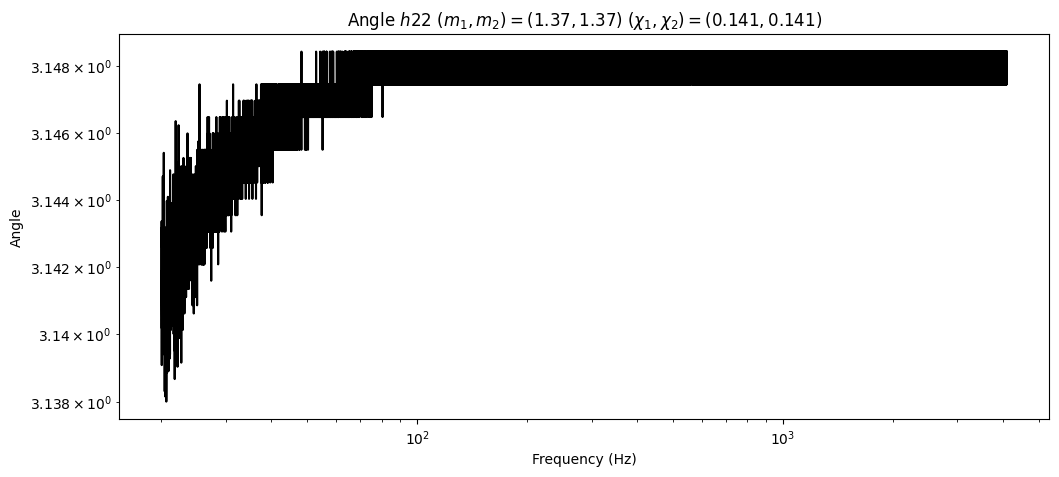

In [119]:
plt.figure(figsize=(12, 5))
plt.plot(f, abs((XAS_angle_LAL - (XAS_angle_ripple))), "-", color="black")
name = "Angle"
# plt.legend()
plt.title(
    r"{} $h22$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$)".format(
        name, m1, m2, chi1, chi2
    )
)
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale("log")
plt.yscale("log")
plt.show()

/home/robinc/anaconda3/envs/jim_dev_env/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/robinc/anaconda3/envs/jim_dev_env/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


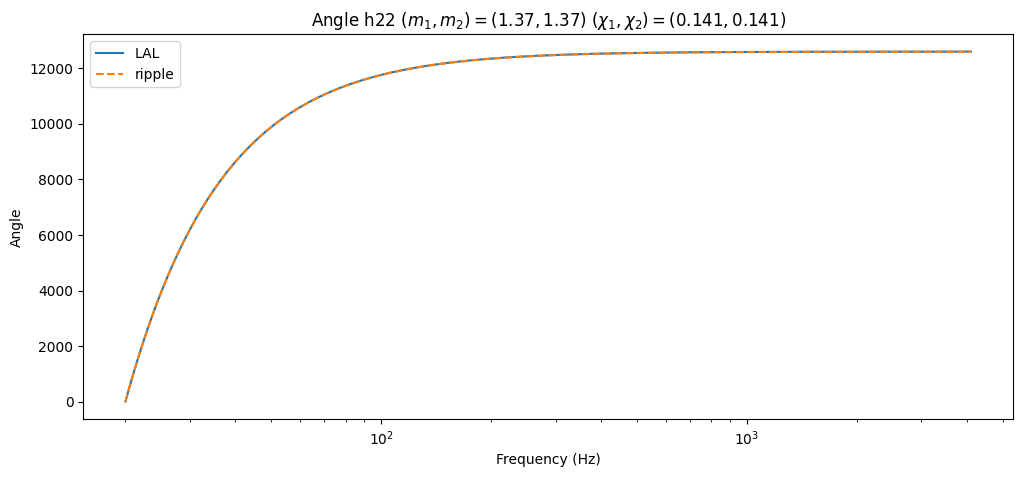

In [120]:
plt.figure(figsize=(12, 5))
plt.plot(f, XAS_angle_LAL, label='LAL')
plt.plot(f, XAS_angle_ripple, label='ripple', ls='--')
# plt.plot(f, fM_s*linb, label=r'linb $fM_s$')
# plt.plot(f, jnp.full_like(f, phifRef), label=r'$\phi_{f_{ref}}$')
name = "Angle"
plt.legend()
plt.title(
    r"{} h22 ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$)".format(
        name, m1, m2, chi1, chi2
    )
)
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale("log")
# plt.yscale("log")
plt.show()

In [121]:
N = 5
rng = np.random.default_rng(seed=42)
masses = rng.uniform(1.2, 30, (N,2))
spins = rng.uniform(0, 0.8, (N,2))

In [105]:
offsets = np.zeros(N**2)
ctr = 0 #yes I'm lazy

for i, ms in enumerate(masses):
    for j, ss in enumerate(spins):
        m1, m2 = ms
        chi1, chi2 = ss

        tc = 0.0 # Time of coalescence in seconds
        phic = 0.0 # Time of coalescence
        dist_mpc = 440 # Distance to source in Mpc -> don't really matter here
        inclination = 0.0 # Inclination Angle -> don't really matter here

        q = m1/m2
        Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
        theta_ripple = jnp.array(
                    [
                        Mc,
                        eta,
                        chi1,
                        chi2,
                        dist_mpc,
                        tc,
                        phic,
                        inclination,
                    ]
                )
        
        ### ripple computation ###
        XAS_angle_ripple, lina, linb, fM_s, phifRef, psi4tostrain = gen_IMRPhenomXAS(fs_ripple, theta_ripple, f_ref, get_phase=True)


        ### LAL computation ###
        m1_kg = m1 * lal.MSUN_SI
        m2_kg = m2 * lal.MSUN_SI
        distance = dist_mpc * 1e6 * lal.PC_SI

        laldict_OnlyPhase = lal.CreateDict()

        # Specify we only want the phase contribution. This exits the function before any NRTidal contributions so don't use this to test tidal phase contributions!
        lalsim.SimInspiralWaveformParamsInsertPhenomXOnlyReturnPhase(laldict_OnlyPhase, 1)

        LAL_OnlyPhase = lalsim.SimIMRPhenomXASGenerateFD(
            m1_kg,
            m2_kg,
            chi1,
            chi2,
            distance,
            f_l,
            f_u,
            df,
            phic,
            f_ref,
            laldict_OnlyPhase,
        )
        XAS_angle_LAL = LAL_OnlyPhase.data.data[mask_lal]

        offset = XAS_angle_LAL[0] - XAS_angle_ripple[0]
        offsets[ctr] += offset.real
        ctr += 1

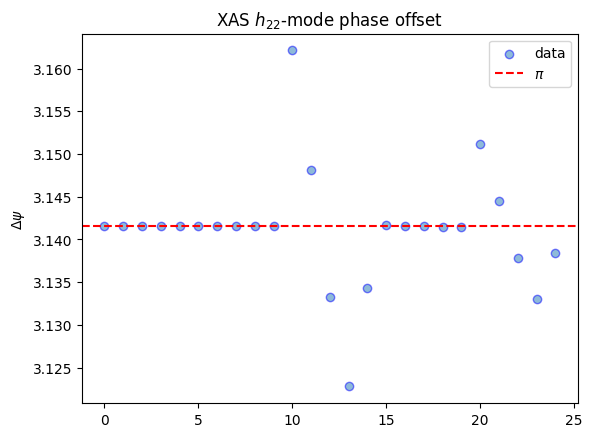

In [109]:
plt.scatter(np.arange(N**2), offsets, edgecolor='blue', alpha=0.5, label='data')
plt.axhline(PI, 0, N**2, ls='--', c='r', label=r'$\pi$')
plt.ylabel(r'$\Delta \psi$')
plt.title(r'XAS $h_{22}$-mode phase offset')
plt.legend()
plt.show()